In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm

from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings("ignore")


DATA_DIR = '../data/'
RANDOM_SEED = 42

In [2]:
df = pd.read_csv(DATA_DIR + 'assr_data.csv').set_index('Subject')

In [3]:
td_info = pd.read_csv(DATA_DIR + 'td_info.csv', index_col=0).dropna(subset='gender')
asd_info = pd.read_csv(DATA_DIR + 'asd_info.csv', index_col=0).dropna(subset='Пол')

In [4]:
td_info['gender'] = td_info['gender'].apply(lambda x: int(x.lower() == 'm'))
asd_info['gender'] = asd_info['Пол'].apply(lambda x: int(x.lower() == 'm'))

In [5]:
age = pd.concat([td_info[['gender']], asd_info[['gender']]])

In [6]:
df = df.join(age, how='left')

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df['age'] = df['age'].str.replace(',', '.')
df['assr'] = df['assr'].str.replace(',', '.')

In [9]:
df['age'] = df['age'].astype(float)
df['assr'] = df['assr'].astype(float)

In [10]:
td = df[df['group'] == 'TD']
asd = df[df['group'] == 'ASD']

## Статистический анализ

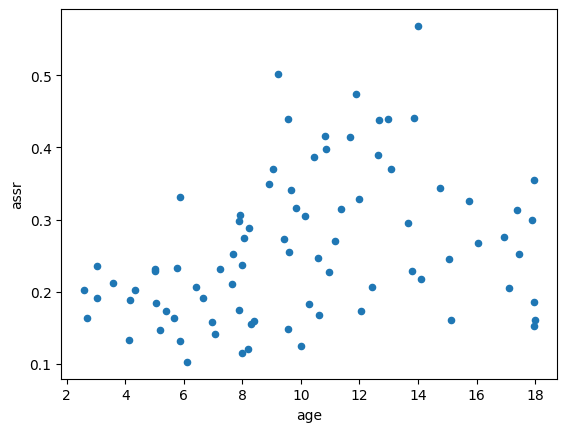

In [11]:
# норма
td.plot(kind='scatter', x='age', y='assr');

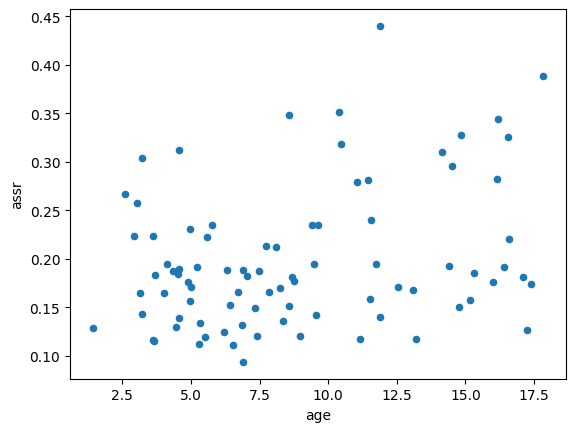

In [12]:
# рас
asd.plot(kind='scatter', x='age', y='assr');

In [13]:
asd['assr'].mean()

np.float64(0.1982342588235294)

In [14]:
td['assr'].mean()

np.float64(0.25958255421686754)

Средний ITPC у нормотипичных детей и детей с РАС, вроде, сильно отличаются, но у нас выборки с различным распределением возраста, что может вносить вклад:

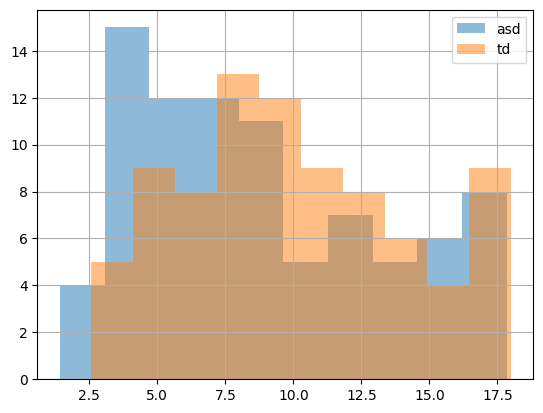

In [15]:
asd['age'].hist(alpha=0.5, label='asd')
td['age'].hist(alpha=0.5, label='td')
plt.legend();

In [16]:
df['bin'] = pd.qcut(df['age'], 6)

In [17]:
df.groupby(['bin', 'group'])[['assr', 'age']].agg(['mean', 'count'])

assr              age      
                           mean count       mean count
bin             group                                 
(1.419, 4.96]   ASD    0.190102    20   3.711000    20
                TD     0.191127     8   3.445000     8
(4.96, 6.907]   ASD    0.158504    16   5.851250    16
                TD     0.193772    12   5.660833    12
(6.907, 8.715]  ASD    0.185172    13   7.870769    13
                TD     0.208231    15   7.833333    15
(8.715, 11.15]  ASD    0.216875    10   9.890000    10
                TD     0.301097    19  10.032105    19
(11.15, 14.543] ASD    0.225567    12  12.660833    12
                TD     0.353544    15  12.813333    15
(14.543, 17.99] ASD    0.230644    14  16.254286    14
                TD     0.253114    14  16.815714    14

#### ANCOVA

In [18]:
# log transform, чтобы снизить возможную гетероскедастичность и приблизить значения ASSR к нормальному распределению
td['log_assr'] = np.log(td['assr'])
asd['log_assr'] = np.log(asd['assr'])

##### Проверка предпосылок

In [19]:
# нормальность распределения
stats.shapiro(td['log_assr']), stats.shapiro(asd['log_assr'])

(ShapiroResult(statistic=np.float64(0.9879276554124581), pvalue=np.float64(0.6354299170378481)),
 ShapiroResult(statistic=np.float64(0.9728423310296674), pvalue=np.float64(0.06959118084270122)))

In [20]:
# гомоскедастичность дисперсии в двух группах
var_data = pd.DataFrame({
    'group': td.shape[0] * ['TD'] + asd.shape[0] * ['ASD'],
    'value': list(td['log_assr']) + list(asd['log_assr'])
})
pg.homoscedasticity(data=var_data, dv='value', group='group', method='levene')

,W,pval,equal_var
levene,2.950824,0.087698,True


In [21]:
# гомоскедастичность остатков
td_linreg = OLS(td['log_assr'], sm.add_constant(td['age'])).fit()
asd_linreg = OLS(asd['log_assr'], sm.add_constant(asd['age'])).fit()

td_residuals = td['log_assr'] - td_linreg.predict(sm.add_constant(td['age']))
asd_residuals = asd['log_assr'] - asd_linreg.predict(sm.add_constant(asd['age']))


residuals_data = pd.DataFrame({
    'group': ['asd'] * asd.shape[0] + ['td'] * td.shape[0],
    'value': list(asd_residuals) + list(td_residuals)
})
pg.homoscedasticity(data=residuals_data, dv='value', group='group', method='levene')

,W,pval,equal_var
levene,1.039392,0.309446,True


In [22]:
stats.shapiro(residuals_data['value'])

ShapiroResult(statistic=np.float64(0.9890365168509879), pvalue=np.float64(0.21845623431155195))

In [23]:
# homogenity of slopes
import statsmodels.formula.api as smf

age_data = var_data = pd.DataFrame({
    'group': td.shape[0] * ['TD'] + asd.shape[0] * ['ASD'],
    'value': list(td['log_assr']) + list(asd['log_assr']),
    'age': list(td['age']) + list(asd['age']),
    'gender': list(td['gender']) + list(asd['gender'])
})
smf.ols('value ~ age * group + gender * group', data=age_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     6.991
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           6.77e-06
Time:                        22:51:38   Log-Likelihood:                -56.204
No. Observations:                 155   AIC:                             124.4
Df Residuals:                     149   BIC:                             142.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.8563      0.133    -13.957      0.000      -2.119      -1.593
group[T.TD]            0.1231      0.170      0.725      0.470      -0.213       0.459
age                    0.0215      0.010      2.198      0.030       0.002       0.041
age:group[T.TD]        0.0098      0.014      0.728      0.468      -0.017       0.037
gender                -0.0039      0.099     -0.039      0.969      -0.199       0.192
gender:group[T.TD]    -0.0041      0.127     -0.032      0.974      -0.254       0.246
==============================================================================
Omnibus:                        5.490   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                2.923
Skew:                           0.038   Prob(JB):                        0.232
Kurtosis:                       2.332   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Нельзя отвергнуть гипотезу о равенстве наклонов.

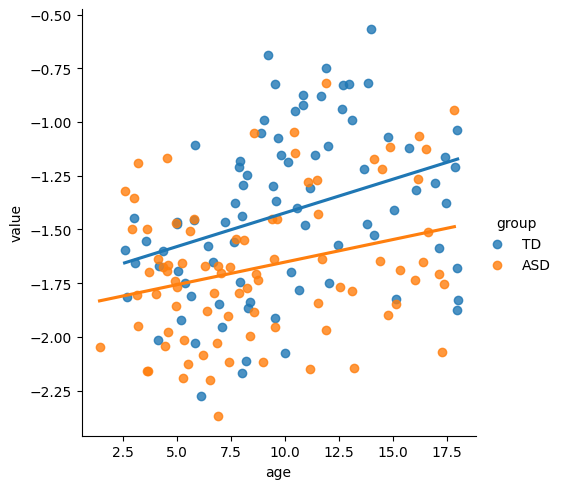

In [24]:
sns.lmplot(x="age", y="value", hue="group", data=age_data, ci=None);

In [25]:
df['log_assr'] = np.log(df['assr'])
ancova = pg.ancova(data=df, dv='log_assr', covar=['age', 'gender'], between='group')
ancova['p-adj'] = multipletests(ancova['p-unc'], method='bonferroni')[1]
ancova

,Source,SS,DF,F,p-unc,np2,p-adj
0,group,1.558706,1,12.512471,0.000537,0.076523,0.002149
1,age,1.988632,1,15.963685,0.000101,0.095612,0.000402
2,gender,0.000099,1,0.000798,0.977497,0.000005,1.000000
3,Residual,18.810406,151,NaN,NaN,NaN,NaN


__Выводы:__

1. ASSR зависит от возраста (p < .001)
2. ASSR различен у нормотипичных детей и у детей с РАС (p < .01)
3. ASSR не зависит от пола

#### Корреляция

__Пирсона__

In [53]:
corr = []
p_vals_corr = []

In [54]:
p_vals_corr.append(stats.pearsonr(td['age'], td['assr'])[1])
corr.append(stats.pearsonr(td['age'], td['assr'])[0])
stats.pearsonr(td['age'], td['assr'])

PearsonRResult(statistic=np.float64(0.3311760754309248), pvalue=np.float64(0.0022267440028145478))

In [55]:
p_vals_corr.append(stats.pearsonr(asd['age'], asd['assr'])[1])
corr.append(stats.pearsonr(asd['age'], asd['assr'])[0])
stats.pearsonr(asd['age'], asd['assr'])

PearsonRResult(statistic=np.float64(0.29492522444134567), pvalue=np.float64(0.006143044470404898))

__Спирмена__

In [56]:
p_vals_corr.append(stats.spearmanr(td['age'], td['assr'])[1])
corr.append(stats.spearmanr(td['age'], td['assr'])[0])
stats.spearmanr(td['age'], td['assr'])

SignificanceResult(statistic=np.float64(0.3855397662527298), pvalue=np.float64(0.00031898446108032244))

In [57]:
p_vals_corr.append(stats.spearmanr(asd['age'], asd['assr'])[1])
corr.append(stats.spearmanr(asd['age'], asd['assr'])[0])
stats.spearmanr(asd['age'], asd['assr'])

SignificanceResult(statistic=np.float64(0.21989661811307862), pvalue=np.float64(0.043160590055766154))

In [58]:
pd.DataFrame({'type': ['TD pearson', 'ASD pearson', 'TD spearman', 'ASD spearman'],
              'corr_val': corr,
              'p-val': p_vals_corr,
              'adj. p-val': multipletests(p_vals_corr, method='bonferroni')[1]
             })

,type,corr_val,p-val,adj. p-val
0,TD pearson,0.331176,0.002227,0.008907
1,ASD pearson,0.294925,0.006143,0.024572
2,TD spearman,0.385540,0.000319,0.001276
3,ASD spearman,0.219897,0.043161,0.172642


И у нормотипичных детей, и у детей с РАС стат. значимая корреляция Пирсона между возрастом и ITPC.

### SRS

In [62]:
td_srs = pd.read_csv(DATA_DIR + 'td_srs_data.csv', index_col=0).T.iloc[:, -6:]
td_srs = td_srs.join(df, how='inner')

In [63]:
asd_srs = pd.read_csv(DATA_DIR + 'srs_data.csv', index_col=0).T.iloc[:, -6:]
asd_srs = asd_srs.join(df, how='inner')

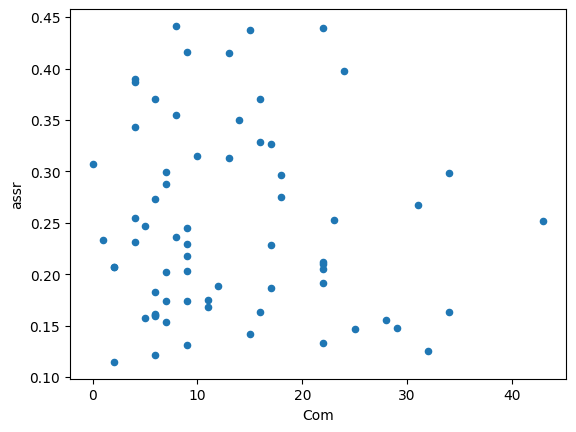

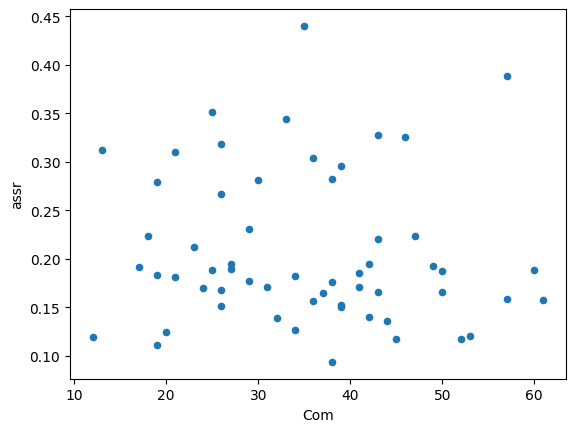

In [64]:
td_srs.plot(kind='scatter', x='Com', y='assr')
asd_srs.plot(kind='scatter', x='Com', y='assr');

In [65]:
stats.pearsonr(td_srs['assr'], td_srs['Com'])

PearsonRResult(statistic=np.float64(-0.06485731515681505), pvalue=np.float64(0.6020610370570848))

In [66]:
stats.pearsonr(asd_srs['assr'], asd_srs['Com'])

PearsonRResult(statistic=np.float64(-0.08254475994565218), pvalue=np.float64(0.5378878703145433))

In [67]:
stats.pearsonr(td_srs['assr'], td_srs['Total'])

PearsonRResult(statistic=np.float64(-0.02691430609302638), pvalue=np.float64(0.8288347045899194))

In [68]:
stats.pearsonr(asd_srs['assr'], asd_srs['Total'])

PearsonRResult(statistic=np.float64(-0.05453194186491482), pvalue=np.float64(0.6843274863193496))

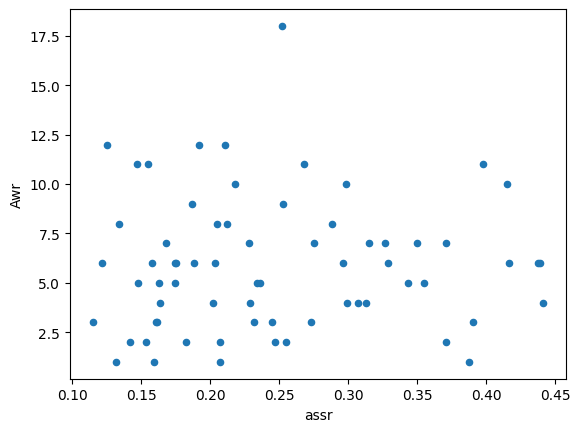

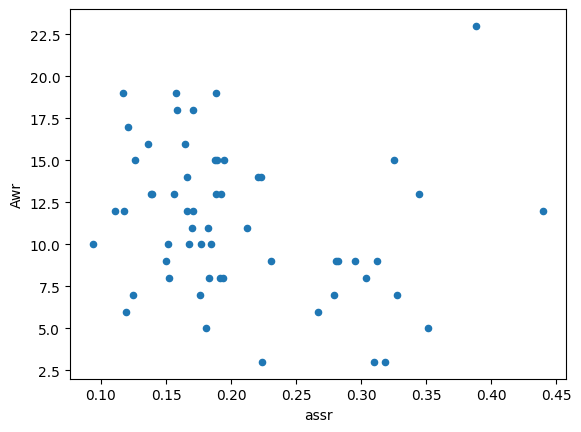

In [69]:
td_srs.plot(kind='scatter', x='assr', y='Awr')
asd_srs.plot(kind='scatter', x='assr', y='Awr');

In [70]:
stats.spearmanr(td_srs['assr'], td_srs['Awr'])

SignificanceResult(statistic=np.float64(0.07200209556792025), pvalue=np.float64(0.5625731779371294))

In [73]:
stats.spearmanr(asd_srs['assr'], asd_srs['Awr'])

SignificanceResult(statistic=np.float64(-0.2820579054456538), pvalue=np.float64(0.03194560096947192))

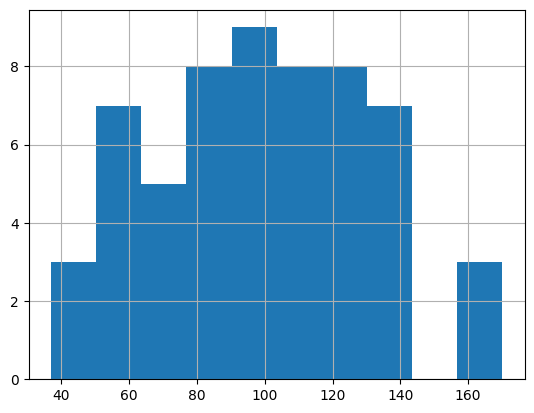

In [201]:
asd_srs['Total'].hist(bins=10);

## Линейная регрессия

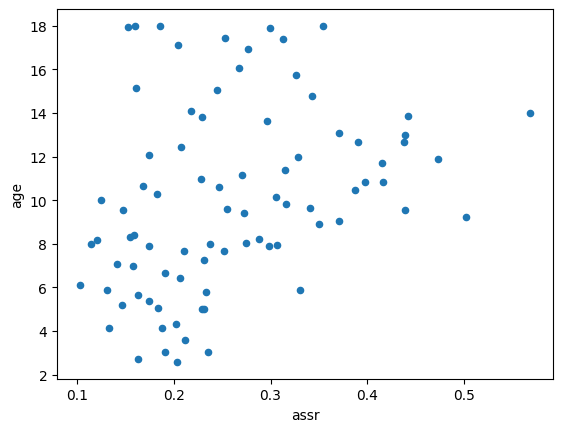

In [280]:
td.plot(kind='scatter', x='assr', y='age');

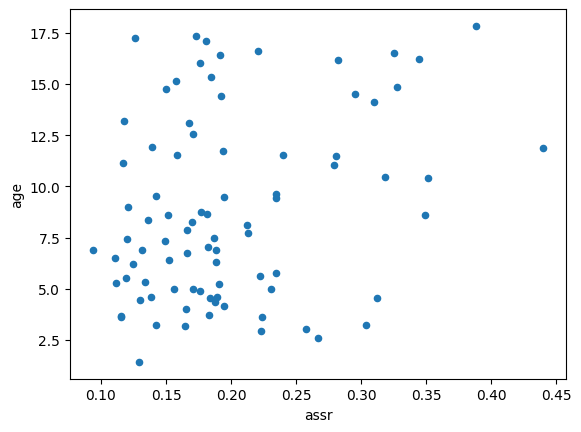

In [281]:
asd.plot(kind='scatter', x='assr', y='age');

Кажется, что здесь может быть нелинейная зависимость. В эксельке наивысший R^2 у степенной зависимости (без разбиения на тест и трейн):
https://docs.google.com/spreadsheets/d/1XzapDAItTLVvwwmQ3lVM1jv1u0hK0HeRYkD4U3ha1Bw/edit?usp=sharing

In [381]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.metrics import root_mean_squared_error as rmse, mean_squared_error as mse, mean_absolute_error as mae, r2_score, \
    roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score, RocCurveDisplay
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


RANDOM_SEED = 42
N_FOLDS = 4
cv_generator = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [158]:
class ConstantModel(BaseEstimator):
    
    def __init__(self, type='mean'):
        assert type in ('mean', 'median')
        self.type = type
        
    def fit(self, X, y):
        if self.type == 'mean':
            self.pred = y.mean()
        else:
            self.pred = y.median()
            
    def predict(self, X):
        return [self.pred] * X.shape[0]

In [159]:
def print_metrics(cv_res):
    print('test mean MAE:', -cv_res['test_neg_mean_absolute_error'].mean().round(3), '±', cv_res['test_neg_mean_absolute_error'].std().round(3))
    print('test mean MSE:', -cv_res['test_neg_mean_squared_error'].mean().round(3), '±', cv_res['test_neg_mean_squared_error'].std().round(3))
    print('test mean RMSE:', -cv_res['test_neg_root_mean_squared_error'].mean().round(3), '±', cv_res['test_neg_root_mean_squared_error'].std().round(3))
    print('test mean R^2:', cv_res['test_r2'].mean().round(3), '±', cv_res['test_r2'].std().round(3))

In [160]:
X = td[['assr']]
y = td['age']

In [161]:
metrics = ['neg_mean_absolute_error', 
           'neg_mean_squared_error',
           'neg_root_mean_squared_error',
           'r2'
          ]

In [162]:
model = ConstantModel('mean')
cv_res = cross_validate(model, X, y, cv=cv_generator, scoring=metrics, 
               return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.496 ± 0.378
test mean MSE: 17.983 ± 2.606
test mean RMSE: 4.229 ± 0.318
test mean R^2: -0.071 ± 0.075


In [163]:
model = ConstantModel('median')
cv_res = cross_validate(model, X, y, cv=cv_generator, scoring=metrics, 
               return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.467 ± 0.423
test mean MSE: 17.979 ± 3.026
test mean RMSE: 4.224 ± 0.374
test mean R^2: -0.065 ± 0.051


In [164]:
model = LinearRegression()
cv_res = cross_validate(model, X, y, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.18 ± 0.216
test mean MSE: 15.905 ± 2.223
test mean RMSE: 3.978 ± 0.289
test mean R^2: 0.05 ± 0.084


In [165]:
poly = PolynomialFeatures()
X_poly = poly.fit_transform(X)[:, 1:]

In [166]:
model = LinearRegression()
cv_res = cross_validate(model, X_poly, y, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.212 ± 0.206
test mean MSE: 15.913 ± 1.897
test mean RMSE: 3.982 ± 0.243
test mean R^2: 0.045 ± 0.107


Посмотрим метрики модели на детях с РАС:

In [167]:
model = LinearRegression()
cv_res = cross_validate(model, X, y, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)

In [168]:
best_model = cv_res['estimator'][0]

In [169]:
X_asd = asd[['assr']]
y_asd = asd['age']

In [170]:
print('MAE:', np.round(mae(y_asd, best_model.predict(X_asd)), 3))
print('MSE:', np.round(mse(y_asd, best_model.predict(X_asd)), 3))
print('RMSE:', np.round(rmse(y_asd, best_model.predict(X_asd)),3))
print('R^2:', np.round(r2_score(y_asd, best_model.predict(X_asd)), 3))

MAE: 3.557
MSE: 18.342
RMSE: 4.283
R^2: 0.081


Построим модель на данных ASD

In [171]:
model = ConstantModel('mean')
cv_res = cross_validate(model, X_asd, y_asd, cv=cv_generator, scoring=metrics, 
               return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.893 ± 0.301
test mean MSE: 21.047 ± 2.552
test mean RMSE: 4.579 ± 0.284
test mean R^2: -0.133 ± 0.042


In [172]:
model = ConstantModel('median')
cv_res = cross_validate(model, X_asd, y_asd, cv=cv_generator, scoring=metrics, 
               return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.83 ± 0.348
test mean MSE: 22.03 ± 4.754
test mean RMSE: 4.665 ± 0.522
test mean R^2: -0.172 ± 0.142


In [173]:
model = LinearRegression()
cv_res = cross_validate(model, X_asd, y_asd, cv=cv_generator, scoring=metrics, 
               return_estimator=True, return_train_score=True)
print_metrics(cv_res)

test mean MAE: 3.646 ± 0.219
test mean MSE: 19.637 ± 1.782
test mean RMSE: 4.427 ± 0.203
test mean R^2: -0.065 ± 0.11


В целом, модель, построенная на данных ASD, сильнее ошибается

## Логистическая регрессия – предсказание наличия ASD

In [174]:
df['target'] = (df['group'] == 'ASD').astype(float)

In [297]:
# баланс классов
df['target'].mean().round(3)

np.float64(0.506)

Для предсказания использую ASSR и AGE. 

In [319]:
X = df[['age', 'assr']]
y = df['target']

__Nested CV__

- Outer - StratifiedKFold (K=4)
- Inner - LogisticRegressionCV (тоже StratifiedKFold, K=4)

In [320]:
outer_cv = StratifiedKFold(n_splits=N_FOLDS, random_state=RANDOM_SEED, shuffle=True)

In [321]:
cv_info = {
    'fold':  [],
    'model': [],
    'pred': [],
    'y_pred': [],
    'y_true': []
          }

for i, (train_index, test_index) in enumerate(outer_cv.split(X, y)):
    model = make_pipeline(StandardScaler(), 
                          LogisticRegressionCV(
                              Cs=list(np.power(10.0, np.arange(-10, 10))), 
                              cv=N_FOLDS, 
                              random_state=RANDOM_SEED)
                         )
    model.fit(X.iloc[train_index], y.iloc[train_index])
    preds = model.predict_proba(X.iloc[test_index])
    y_preds = model.predict(X.iloc[test_index])
    
    cv_info['fold'].append(i + 1)
    cv_info['model'].append(model)
    cv_info['pred'].append(preds[:, 1])
    cv_info['y_pred'].append(y_preds)
    cv_info['y_true'].append(y.iloc[test_index])

In [333]:
cv_metrics = {'fold': [i + 1 for i in range(N_FOLDS)],
              'auc': [],
              'fpr': [],
              'tpr': [],
              'precision': [],
              'recall': [],
              'f1': [],
              'accuracy': []
             }

for i in range(N_FOLDS):
    fpr, tpr, _ = roc_curve(cv_info['y_true'][i], cv_info['pred'][i])
    auc_val = auc(fpr, tpr)
    precision = precision_score(cv_info['y_true'][i], cv_info['y_pred'][i])
    recall = recall_score(cv_info['y_true'][i], cv_info['y_pred'][i])
    f1 = f1_score(cv_info['y_true'][i], cv_info['y_pred'][i])
    acc = accuracy_score(cv_info['y_true'][i], cv_info['y_pred'][i])
    
    cv_metrics['auc'].append(auc_val)
    cv_metrics['fpr'].append(fpr.tolist())
    cv_metrics['tpr'].append(tpr.tolist())
    cv_metrics['precision'].append(recall)
    cv_metrics['recall'].append(auc_val)
    cv_metrics['f1'].append(f1)
    cv_metrics['accuracy'].append(acc)

In [334]:
print('roc auc:', np.mean(cv_metrics['auc']).round(2), '±', np.std(cv_metrics['auc']).round(2))
print('precision:', np.mean(cv_metrics['precision']).round(2), '±', np.std(cv_metrics['precision']).round(2))
print('recall:', np.mean(cv_metrics['recall']).round(2), '±', np.std(cv_metrics['recall']).round(2))
print('f1:', np.mean(cv_metrics['f1']).round(2), '±', np.std(cv_metrics['f1']).round(2))
print('accuracy:', np.mean(cv_metrics['accuracy']).round(2), '±', np.std(cv_metrics['accuracy']).round(2))

roc auc: 0.68 ± 0.05
precision: 0.69 ± 0.07
recall: 0.68 ± 0.05
f1: 0.66 ± 0.03
accuracy: 0.63 ± 0.04


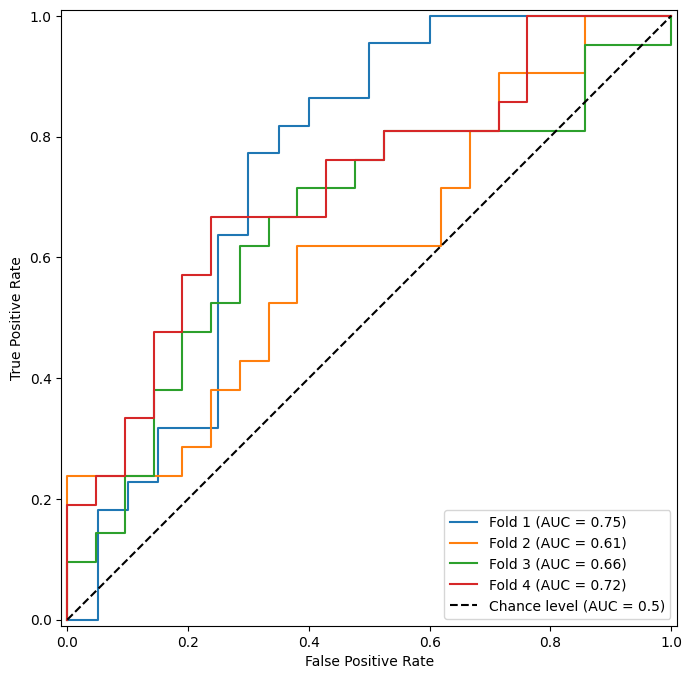

In [406]:
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(N_FOLDS):
    RocCurveDisplay(fpr=cv_metrics['fpr'][i], 
                    tpr=cv_metrics['tpr'][i], 
                    roc_auc=cv_metrics['auc'][i]
                   ).plot(ax=ax, name=f'Fold {i + 1}', plot_chance_level=(i == 3))